## Deep Learning


### 1. Import and load dataset

In [13]:
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2

In [4]:
local_file_path = "crime_data.pkl"
file_id = "16Yg-rMcVEOJ57pN6z-LFaHK4YrXSin__"

if not os.path.exists(local_file_path):
    print("File not found, downloading...")
    import gdown
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, local_file_path, quiet=False)
else:
    print("File found, loading...")

crime_df = pd.read_pickle(local_file_path)
print(crime_df.head())

File not found, downloading...


Downloading...
From: https://drive.google.com/uc?id=16Yg-rMcVEOJ57pN6z-LFaHK4YrXSin__
To: /content/crime_data.pkl
100%|██████████| 19.6M/19.6M [00:00<00:00, 87.3MB/s]


        Date                  Block                Primary Type  \
0 2024-10-18      051XX S HOMAN AVE  OFFENSE INVOLVING CHILDREN   
1 2024-10-10  091XX S EGGLESTON AVE         MOTOR VEHICLE THEFT   
2 2024-10-10   009XX N LAWNDALE AVE          DECEPTIVE PRACTICE   
3 2024-10-10  045XX N CLARENDON AVE             CRIMINAL DAMAGE   
4 2024-10-10    108XX S CALHOUN AVE                     BATTERY   

  Location Description District Ward Community Area   Latitude  Longitude  \
0            RESIDENCE        8   14             63  41.799867 -87.708644   
1               STREET       22    9             73  41.728316 -87.634933   
2            APARTMENT       11   27             23  41.897826  -87.71883   
3               STREET       19   46              3   41.96388 -87.649971   
4            APARTMENT        4   10             51  41.698661 -87.561961   

       DateTime Hour is_Holiday  PRCP  SNOW  TAVG  
0  1.729210e+09    0      False   0.0   0.0  12.6  
1  1.728518e+09    0      Fals

### 1.1 Debug dataset (switch it when testing on small scale)

In [ ]:
# local_file_path = "crime_data_debug.pkl"
# file_id = "1-UjFOS0JjPk1OSV3KPic29GLalFVdV9s"

# if not os.path.exists(local_file_path):
#     print("File not found, downloading...")
#     import gdown
#     url = f"https://drive.google.com/uc?id={file_id}"
#     gdown.download(url, local_file_path, quiet=False)
# else:
#     print("File found, loading...")

# crime_df = pd.read_pickle(local_file_path)
# print(crime_df.head())

### 2. Model
The model is designed to predict crime types. To address the class imbalance in the dataset, we selected the 10 most frequent crime types and grouped all other less common types into a single category labeled "Others." To ensure fair representation, we balanced the dataset by equalizing the number of training samples for each crime type, including "Others."

In [5]:
#dataset balance - sampling
def balance_dataset(df):
    # Count label frequencies
    label_counts = df['Primary Type'].value_counts()

    # Get the top 5 labels
    top_5_labels = label_counts.nlargest(10).index

    # Filter for top 5 labels
    df_top_5 = df[df['Primary Type'].isin(top_5_labels)]

    # Set target frequency as the mean of the top 5 labels' frequencies
    target_frequency = label_counts[top_5_labels].mean()

    # Resample each label to the target frequency
    smoothed_dfs = []
    for label in top_5_labels:
        label_df = df_top_5[df_top_5['Primary Type'] == label]
        smoothed_label_df = resample(
            label_df,
            replace=True,  # Oversample or undersample
            n_samples=int(target_frequency),
            random_state=42
        )
        smoothed_dfs.append(smoothed_label_df)

    # Combine smoothed data
    df_smoothed = pd.concat(smoothed_dfs)
    df_smoothed = df_smoothed.reset_index(drop=True)

    # Group remaining labels into "Others"
    df['Primary Type'] = df['Primary Type'].apply(
        lambda x: x if x in top_5_labels else 'Others'
    )

    # Add smoothed top 5 data to the final dataset
    df_final = pd.concat([df_smoothed, df[df['Primary Type'] == 'Others']])
    df_final = df_final.reset_index(drop=True)

    df_final['Primary Type'].value_counts(normalize=True).plot(kind='bar')
    print(df_final['Primary Type'].value_counts(normalize=True))
    plt.title('Label Bias')
    plt.ylabel('Bias')
    plt.xlabel('Primary Type')
    plt.show()
    return df_final



<ipython-input-52-9b0b9a1b2106>:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.fillna(0, inplace=True)


Epoch 1/20
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 51s 12ms/step - accuracy: 0.3835 - loss: 1.5520 - val_accuracy: 0.5486 - val_loss: 1.0907
Epoch 2/20
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 80s 12ms/step - accuracy: 0.5315 - loss: 1.1404 - val_accuracy: 0.6033 - val_loss: 0.9643
Epoch 3/20
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 87s 13ms/step - accuracy: 0.5978 - loss: 0.9716 - val_accuracy: 0.6350 - val_loss: 0.8354
Epoch 4/20
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 78s 12ms/step - accuracy: 0.6259 - loss: 0.8952 - val_accuracy: 0.6570 - val_loss: 0.8003
Epoch 5/20
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.6403 - loss: 0.8594 - val_accuracy: 0.6862 - val_loss: 0.7382
Epoch 6/20
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.6596 - loss: 0.8018 - val_accuracy: 0.6954 - val_loss: 0.7191
Epoch 7/20
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 91s 14ms/step - accuracy: 0.6742 - loss: 0.7692 - val_accuracy: 0.6915 - val_loss: 0.6921
Epoch 8/20
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 52s 13ms/step - accuracy: 0.6920 -

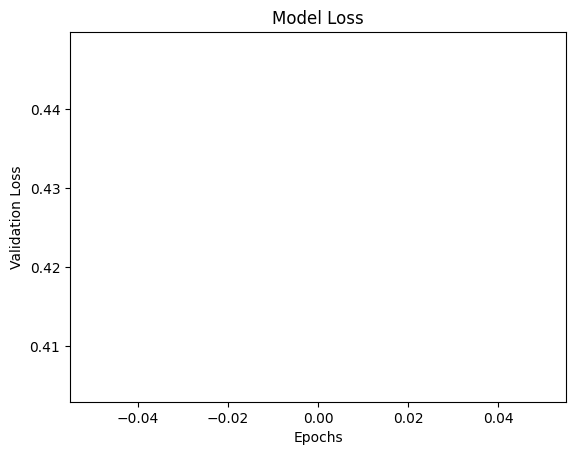

In [ ]:
# Balance dataset
crime_df = balance_dataset(crime_df)

# Convert 'is_Holiday' to binary
crime_df['is_Holiday'] = crime_df['is_Holiday'].astype(str).map({'False': 0, 'True': 1})

# Encode 'Primary Type' and 'Location Description'
label_encoder_primary = LabelEncoder()
crime_df['Primary Type Encoded'] = label_encoder_primary.fit_transform(crime_df['Primary Type'])

label_encoder_location = LabelEncoder()
crime_df['Location Description Encoded'] = label_encoder_location.fit_transform(crime_df['Location Description'])

crime_df['Date'] = pd.to_datetime(crime_df['Date'])



X = crime_df[['Date', 'Hour', 'is_Holiday', 'PRCP', 'SNOW', 'TAVG', 'Latitude', 'Longitude',
              'District', 'Ward', 'Community Area', 'Location Description Encoded']].copy()
y = crime_df['Primary Type Encoded']


X = X.sort_values('Date').reset_index(drop=True)
y = y.loc[X.index]

dates = X['Date']
X = X.drop(columns=['Date'])

X.fillna(0, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sequence length
sequence_length = 24

def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_sequences, y_sequences = create_sequences(X_scaled, y.values, sequence_length)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=534, stratify=y_sequences)

# one-hot encode
num_classes = len(np.unique(y))
y_train_categorical = to_categorical(y_train_seq, num_classes)
y_test_categorical = to_categorical(y_test_seq, num_classes)

losses = []

with tf.device('/GPU:0'):
    model = Sequential([
        Input(shape=(sequence_length, X_train_seq.shape[2])),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(128),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train_seq, y_train_categorical, epochs=20, batch_size=32, validation_split=0.2)

    test_loss, test_acc = model.evaluate(X_test_seq, y_test_categorical)
    losses.append(test_loss)
    print('Test accuracy:', test_acc)



In [ ]:
y_pred = model.predict(X_test_seq)

1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


Predicted classes: ['THEFT' 'DECEPTIVE PRACTICE' 'MOTOR VEHICLE THEFT' ... 'ASSAULT'
 'ROBBERY' 'MOTOR VEHICLE THEFT']
Actual classes: ['THEFT' 'DECEPTIVE PRACTICE' 'MOTOR VEHICLE THEFT' ... 'ASSAULT'
 'ROBBERY' 'MOTOR VEHICLE THEFT']


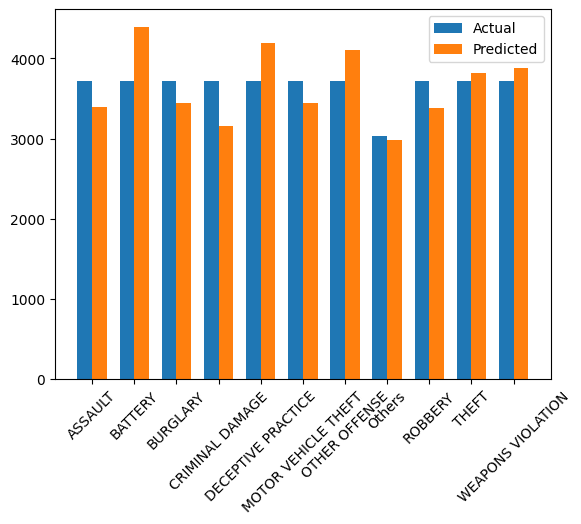

In [ ]:
predicted_classes = np.argmax(y_pred, axis=1)
predicted_class = label_encoder_primary.inverse_transform(predicted_classes)
actual_class = label_encoder_primary.inverse_transform(y_test_seq)
print('Predicted classes:', predicted_class)
print('Actual classes:', actual_class)
classes = np.unique(np.concatenate((actual_class, predicted_class)))
actual_counts = [np.sum(actual_class == cls) for cls in classes]
predicted_counts = [np.sum(predicted_class == cls) for cls in classes]

x_bar = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(x_bar - width/2, actual_counts, width, label='Actual')
bar2 = ax.bar(x_bar + width/2, predicted_counts, width, label='Predicted')

ax.set_xticks(x_bar)
ax.set_xticklabels(classes,rotation=45)
ax.legend()
plt.show()


Confusion Matrix:


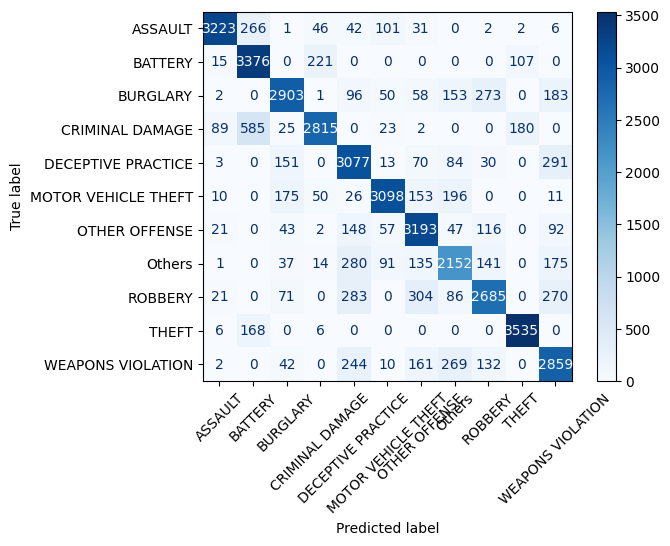

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(actual_class, predicted_class, labels=classes)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("Confusion Matrix:")
# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=45)
plt.show()

### 2.1 Model (Sub-problem)
The model is designed for crime count prediction, using feature like 'Year', 'Month', 'DayOfWeek', 'Hour', 'Community Area', 'Ward', 'District'

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 237.5005 - mae: 10.6428 - val_loss: 227.4595 - val_mae: 9.5872
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100.0198 - mae: 7.3489 - val_loss: 98.6482 - val_mae: 5.9923
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.0824 - mae: 4.4285 - val_loss: 35.0536 - val_mae: 3.7302
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.8468 - mae: 4.0828 - val_loss: 28.7881 - val_mae: 3.3582
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.0205 - mae: 3.7601 - val_loss: 26.6922 - val_mae: 3.1624
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.9399 - mae: 3.7498 - val_loss: 26.7452 - val_mae: 3.1318
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.8965 - mae: 3.5625 - val_loss: 24.3679 - val_mae: 2.9896
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.4063 - mae: 3.4917 - val_loss: 25.0900 - val_mae: 3.1033
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

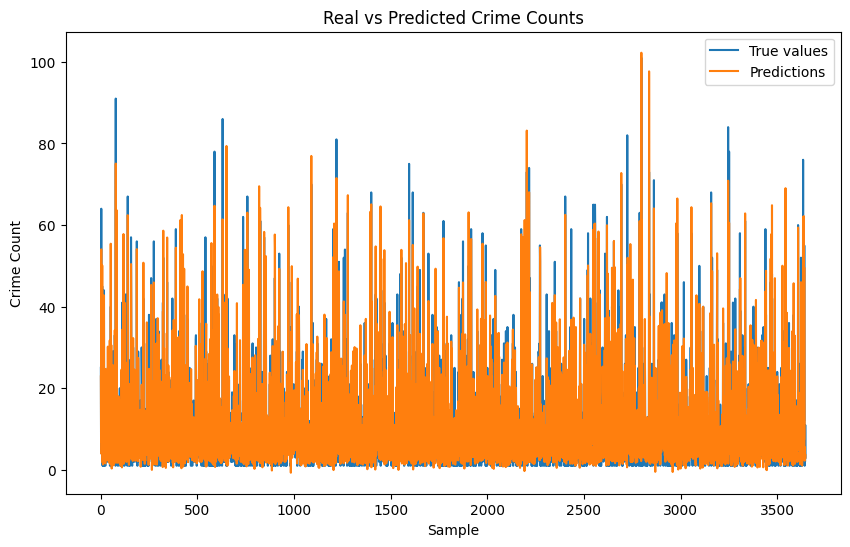

In [ ]:
# Convert date
crime_df['Date'] = pd.to_datetime(crime_df['Date'], errors='coerce')
crime_df = crime_df.dropna(subset=['Date'])

# Extract date features
crime_df['Hour'] = crime_df['Date'].dt.hour
crime_df['DayOfWeek'] = crime_df['Date'].dt.dayofweek
crime_df['Month'] = crime_df['Date'].dt.month
crime_df['Year'] = crime_df['Date'].dt.year

# deal with missing values
crime_df = crime_df.dropna(subset=['Latitude', 'Longitude', 'Community Area'])

crime_df['is_Holiday'] = crime_df['is_Holiday'].map({False: 0, True: 1})
crime_df.head()

# Encode categorical variables
crime_counts = crime_df.groupby(['Year', 'Month', 'DayOfWeek', 'Hour', 'Community Area', 'Ward', 'District']).size().reset_index(name='CrimeCount')
crime_counts.head()

X = crime_counts[['Year', 'Month', 'DayOfWeek', 'Hour', 'Community Area', 'Ward', 'District']]
y = crime_counts['CrimeCount']

# One-hot encode
X = pd.get_dummies(X, columns=['Year', 'Month', 'DayOfWeek', 'Hour', 'Community Area', 'Ward', 'District'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=534)

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

test_loss, test_mae = model.evaluate(X_test, y_test)
print('\nMAE on Test set:', test_mae)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('MAE:', mae)
print('R^2:', r2)

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='True values')
plt.plot(y_pred, label='Predictions')
plt.legend()
plt.title('Real vs Predicted Crime Counts')
plt.xlabel('Sample')
plt.ylabel('Crime Count')
plt.show()


### 3. Mini-batch learning

Using a smaller dataset for evaluation

In [ ]:
local_file_path = "crime_data_debug.pkl"
file_id = "1-UjFOS0JjPk1OSV3KPic29GLalFVdV9s"

if not os.path.exists(local_file_path):
    print("File not found, downloading...")
    import gdown
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, local_file_path, quiet=False)
else:
    print("File found, loading...")

crime_df = pd.read_pickle(local_file_path)
print(crime_df.head())

File not found, downloading...


Downloading...
From: https://drive.google.com/uc?id=1-UjFOS0JjPk1OSV3KPic29GLalFVdV9s
To: /content/crime_data_debug.pkl
100%|██████████| 2.77M/2.77M [00:00<00:00, 20.7MB/s]

        Date                  Block                Primary Type  \
0 2024-10-18      051XX S HOMAN AVE  OFFENSE INVOLVING CHILDREN   
1 2024-10-10  091XX S EGGLESTON AVE         MOTOR VEHICLE THEFT   
2 2024-10-10   009XX N LAWNDALE AVE          DECEPTIVE PRACTICE   
3 2024-10-10  045XX N CLARENDON AVE             CRIMINAL DAMAGE   
4 2024-10-10    108XX S CALHOUN AVE                     BATTERY   

  Location Description District Ward Community Area   Latitude  Longitude  \
0            RESIDENCE        8   14             63  41.799867 -87.708644   
1               STREET       22    9             73  41.728316 -87.634933   
2            APARTMENT       11   27             23  41.897826  -87.71883   
3               STREET       19   46              3   41.96388 -87.649971   
4            APARTMENT        4   10             51  41.698661 -87.561961   

       DateTime Hour is_Holiday  PRCP  SNOW  TAVG  
0  1.729210e+09    0      False   0.0   0.0  12.6  
1  1.728518e+09    0      Fals

Preprocess using same method except no stratifying(not enough sample for some classes)

Primary Type
THEFT                  0.092619
BATTERY                0.092619
CRIMINAL DAMAGE        0.092619
ASSAULT                0.092619
MOTOR VEHICLE THEFT    0.092619
OTHER OFFENSE          0.092619
DECEPTIVE PRACTICE     0.092619
BURGLARY               0.092619
ROBBERY                0.092619
WEAPONS VIOLATION      0.092619
Others                 0.073807
Name: proportion, dtype: float64


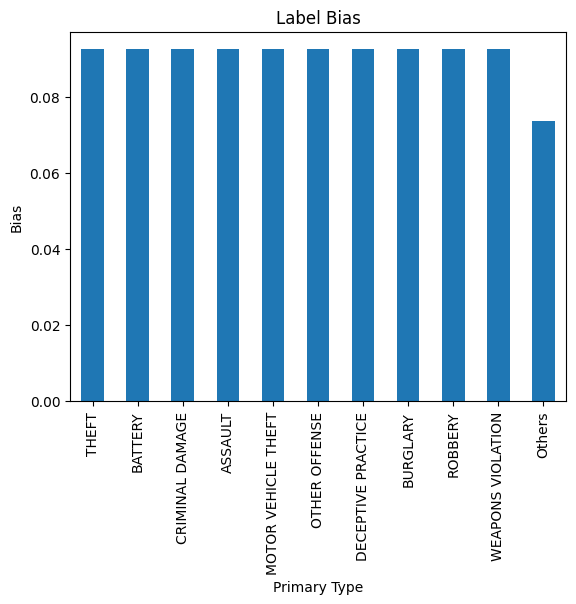

<ipython-input-7-a680c9aa7ef4>:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.fillna(0, inplace=True)


In [ ]:
crime_df = balance_dataset(crime_df)
# Convert 'is_Holiday' to binary
crime_df['is_Holiday'] = crime_df['is_Holiday'].astype(str).map({'False': 0, 'True': 1})

# Encode 'Primary Type' and 'Location Description'
label_encoder_primary = LabelEncoder()
crime_df['Primary Type Encoded'] = label_encoder_primary.fit_transform(crime_df['Primary Type'])

label_encoder_location = LabelEncoder()
crime_df['Location Description Encoded'] = label_encoder_location.fit_transform(crime_df['Location Description'])

crime_df['Date'] = pd.to_datetime(crime_df['Date'])
X = crime_df[['Date', 'Hour', 'is_Holiday', 'PRCP', 'SNOW', 'TAVG', 'Latitude', 'Longitude',
              'District', 'Ward', 'Community Area', 'Location Description Encoded']].copy()
y = crime_df['Primary Type Encoded']

X = X.sort_values('Date').reset_index(drop=True)
y = y.loc[X.index]

dates = X['Date']
X = X.drop(columns=['Date'])

X.fillna(0, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sequence length
sequence_length = 24

def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_sequences, y_sequences = create_sequences(X_scaled, y.values, sequence_length)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=534)

# one-hot encode
num_classes = len(np.unique(y))
y_train_categorical = to_categorical(y_train_seq, num_classes)
y_test_categorical = to_categorical(y_test_seq, num_classes)

Train on different sizes of mini-batches (16, 32, 64, 128)

In [ ]:
batch_sizes = [16, 32, 64, 128, 256]
history_dict = {}
training_times = {}

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    with tf.device('/GPU:0'):
        model = Sequential([
        Input(shape=(sequence_length, X_train_seq.shape[2])),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(128),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        history = model.fit(
            X_train_seq, y_train_categorical,
            epochs=15, batch_size=batch_size,
            validation_split=0.2, verbose=2
        )
        end_time = time.time()

        training_times[batch_size] = end_time - start_time
        history_dict[batch_size] = history.history

Training with batch size: 16
Epoch 1/15
1135/1135 - 17s - 15ms/step - accuracy: 0.4483 - loss: 1.4578 - val_accuracy: 0.5663 - val_loss: 1.0344
Epoch 2/15
1135/1135 - 11s - 10ms/step - accuracy: 0.5742 - loss: 1.0669 - val_accuracy: 0.6534 - val_loss: 0.8257
Epoch 3/15
1135/1135 - 21s - 18ms/step - accuracy: 0.6489 - loss: 0.8651 - val_accuracy: 0.7296 - val_loss: 0.6287
Epoch 4/15
1135/1135 - 20s - 18ms/step - accuracy: 0.6990 - loss: 0.7499 - val_accuracy: 0.7541 - val_loss: 0.5874
Epoch 5/15
1135/1135 - 24s - 21ms/step - accuracy: 0.7464 - loss: 0.6386 - val_accuracy: 0.7545 - val_loss: 0.5971
Epoch 6/15
1135/1135 - 11s - 10ms/step - accuracy: 0.7710 - loss: 0.5786 - val_accuracy: 0.8224 - val_loss: 0.4214
Epoch 7/15
1135/1135 - 20s - 18ms/step - accuracy: 0.7829 - loss: 0.5444 - val_accuracy: 0.8334 - val_loss: 0.3840
Epoch 8/15
1135/1135 - 20s - 17ms/step - accuracy: 0.8164 - loss: 0.4644 - val_accuracy: 0.8347 - val_loss: 0.4132
Epoch 9/15
1135/1135 - 11s - 10ms/step - accuracy: 

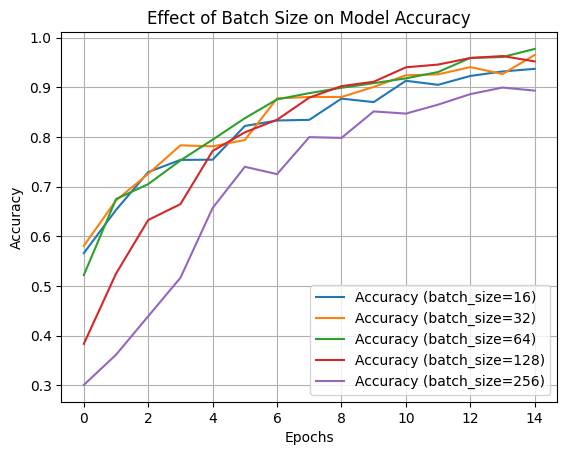

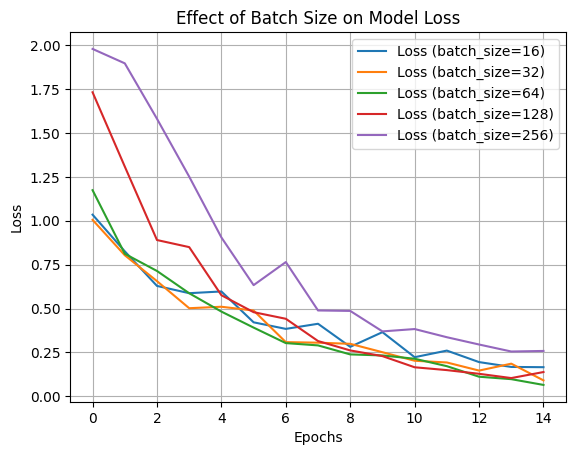

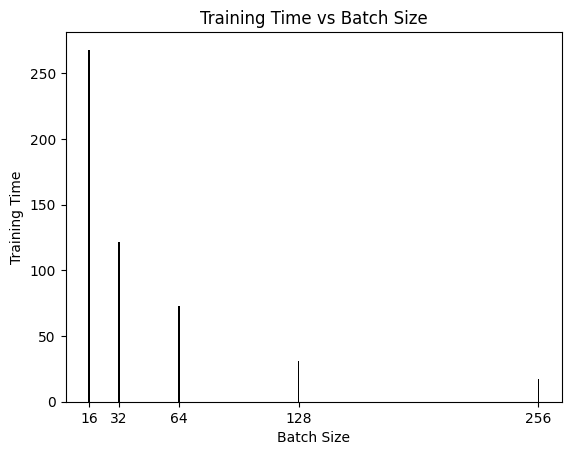

In [ ]:
# Plot accuracy
for batch_size, hist in history_dict.items():
    plt.plot(hist['val_accuracy'], label=f'Accuracy (batch_size={batch_size})')

plt.title('Effect of Batch Size on Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
for batch_size, hist in history_dict.items():
    plt.plot(hist['val_loss'], label=f'Loss (batch_size={batch_size})')

plt.title('Effect of Batch Size on Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot time
plt.bar(batch_sizes, [training_times[bs] for bs in batch_sizes], color='black')
plt.title('Training Time vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Training Time')
plt.xticks(batch_sizes)
plt.show()

### Conclusion

Small batch size makes the accuracy approach to the optimal faster than large batch size. Small batch sizes reduces the loss faster than large batch size. But these differences will diminish as epoches grows.

Small batch size takes longer to complete training due to more frequent weight updates.

Small batch size result in noisy gradient estimates because the gradients are computed on fewer examples. While this noise can sometimes help escape local minima, it can also lead to instability in convergence, making it harder to reach the optimal. As shown in the graph, a batch of size 16 does not perform better than size 32 or 64.

It seems that a batch size of 32 or 64 will achieve a good balance between accuracy and training time.


### 4. Effect of optimizers

Primary Type
THEFT                  0.092619
BATTERY                0.092619
CRIMINAL DAMAGE        0.092619
ASSAULT                0.092619
MOTOR VEHICLE THEFT    0.092619
OTHER OFFENSE          0.092619
DECEPTIVE PRACTICE     0.092619
BURGLARY               0.092619
ROBBERY                0.092619
WEAPONS VIOLATION      0.092619
Others                 0.073807
Name: proportion, dtype: float64


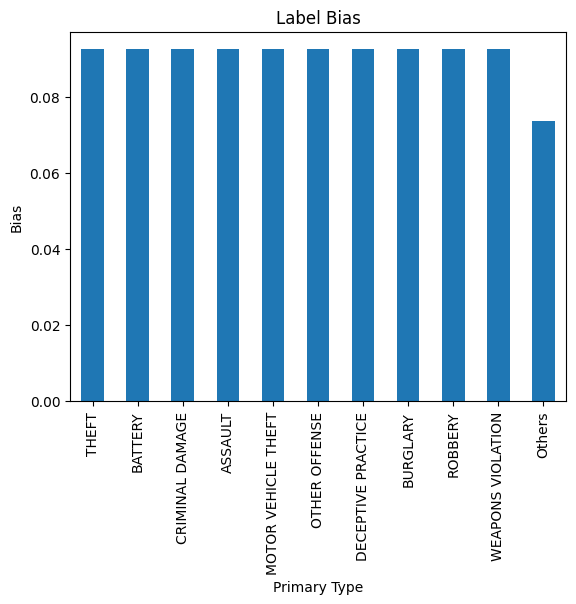

<ipython-input-67-f0a18b104d62>:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.fillna(0, inplace=True)


In [ ]:
# Balance dataset
crime_df = balance_dataset(crime_df)

# Convert 'is_Holiday' to binary
crime_df['is_Holiday'] = crime_df['is_Holiday'].astype(str).map({'False': 0, 'True': 1})

# Encode 'Primary Type' and 'Location Description'
label_encoder_primary = LabelEncoder()
crime_df['Primary Type Encoded'] = label_encoder_primary.fit_transform(crime_df['Primary Type'])

label_encoder_location = LabelEncoder()
crime_df['Location Description Encoded'] = label_encoder_location.fit_transform(crime_df['Location Description'])

crime_df['Date'] = pd.to_datetime(crime_df['Date'])
X = crime_df[['Date', 'Hour', 'is_Holiday', 'PRCP', 'SNOW', 'TAVG', 'Latitude', 'Longitude',
              'District', 'Ward', 'Community Area', 'Location Description Encoded']].copy()
y = crime_df['Primary Type Encoded']

X = X.sort_values('Date').reset_index(drop=True)
y = y.loc[X.index]

dates = X['Date']
X = X.drop(columns=['Date'])

X.fillna(0, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sequence length
sequence_length = 24

def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_sequences, y_sequences = create_sequences(X_scaled, y.values, sequence_length)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=534)

# one-hot encode
num_classes = len(np.unique(y))
y_train_categorical = to_categorical(y_train_seq, num_classes)
y_test_categorical = to_categorical(y_test_seq, num_classes)

In [ ]:
optimizers = ['Adam', 'SGD', 'RMSprop']

history_dict = {}
training_times = {}

for optim in optimizers:
    print(f"Training with optimizer: {optim}")
    with tf.device('/GPU:0'):
        model = Sequential([
            Input(shape=(sequence_length, X_train_seq.shape[2])),
            LSTM(64, return_sequences=True),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(128),
            BatchNormalization(),
            Dropout(0.2),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        history = model.fit(
            X_train_seq, y_train_categorical,
            epochs=10, batch_size=32,
            validation_split=0.2, verbose=0
        )
        end_time = time.time()

        training_times[optim] = end_time - start_time
        history_dict[optim] = history.history


Training with optimizer: Adam
Training with optimizer: SGD
Training with optimizer: RMSprop


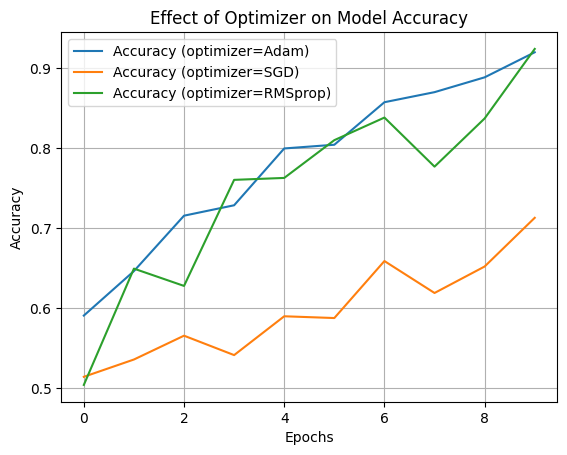

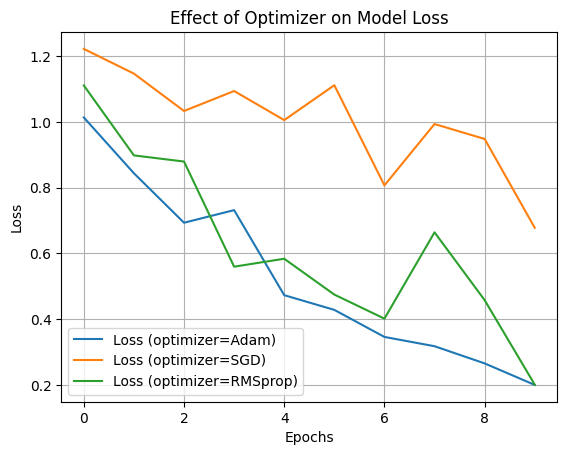

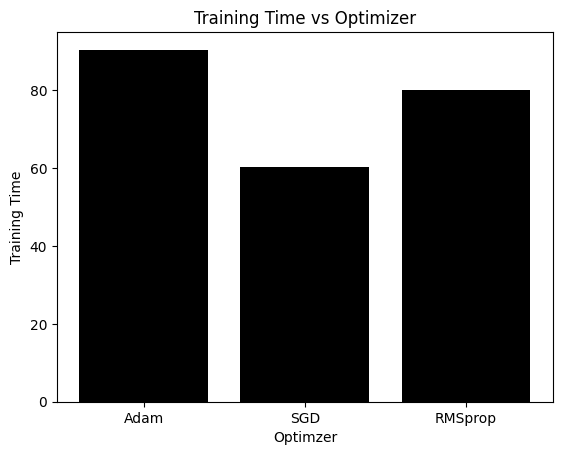

In [ ]:
# Plot accuracy
for optim, hist in history_dict.items():
    plt.plot(hist['val_accuracy'], label=f'Accuracy (optimizer={optim})')

plt.title('Effect of Optimizer on Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
for optim, hist in history_dict.items():
    plt.plot(hist['val_loss'], label=f'Loss (optimizer={optim})')

plt.title('Effect of Optimizer on Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot time
plt.bar(optimizers, [training_times[optim] for optim in optimizers], color='black')
plt.title('Training Time vs Optimizer')
plt.xlabel('Optimzer')
plt.ylabel('Training Time')
plt.xticks(optimizers)
plt.show()

Adma and RMSprop have similar performance while the loss with Adam is more stable. SGD has the worst performace

##Hyperparameters Tuning

Testing differenct hyperparameters:

1.   Learning rate
2.   Dropout rates
3. Number of epochs

For batch size and optimizer has been tested in the previous sections, so we will skip those.



In [10]:
local_file_path = "crime_data_debug.pkl"
file_id = "1-UjFOS0JjPk1OSV3KPic29GLalFVdV9s"

if not os.path.exists(local_file_path):
    print("File not found, downloading...")
    import gdown
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, local_file_path, quiet=False)
else:
    print("File found, loading...")

crime_df = pd.read_pickle(local_file_path)
print(crime_df.head())

File found, loading...
        Date                  Block                Primary Type  \
0 2024-10-18      051XX S HOMAN AVE  OFFENSE INVOLVING CHILDREN   
1 2024-10-10  091XX S EGGLESTON AVE         MOTOR VEHICLE THEFT   
2 2024-10-10   009XX N LAWNDALE AVE          DECEPTIVE PRACTICE   
3 2024-10-10  045XX N CLARENDON AVE             CRIMINAL DAMAGE   
4 2024-10-10    108XX S CALHOUN AVE                     BATTERY   

  Location Description District Ward Community Area   Latitude  Longitude  \
0            RESIDENCE        8   14             63  41.799867 -87.708644   
1               STREET       22    9             73  41.728316 -87.634933   
2            APARTMENT       11   27             23  41.897826  -87.71883   
3               STREET       19   46              3   41.96388 -87.649971   
4            APARTMENT        4   10             51  41.698661 -87.561961   

       DateTime Hour is_Holiday  PRCP  SNOW  TAVG  
0  1.729210e+09    0      False   0.0   0.0  12.6  
1  1.72

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product
def create_model(learning_rate, dropout1, dropout2, dropout3, input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(dropout1),
        LSTM(128),
        BatchNormalization(),
        Dropout(dropout2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(dropout3),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Primary Type
THEFT                  0.092619
BATTERY                0.092619
CRIMINAL DAMAGE        0.092619
ASSAULT                0.092619
MOTOR VEHICLE THEFT    0.092619
OTHER OFFENSE          0.092619
DECEPTIVE PRACTICE     0.092619
BURGLARY               0.092619
ROBBERY                0.092619
WEAPONS VIOLATION      0.092619
Others                 0.073807
Name: proportion, dtype: float64


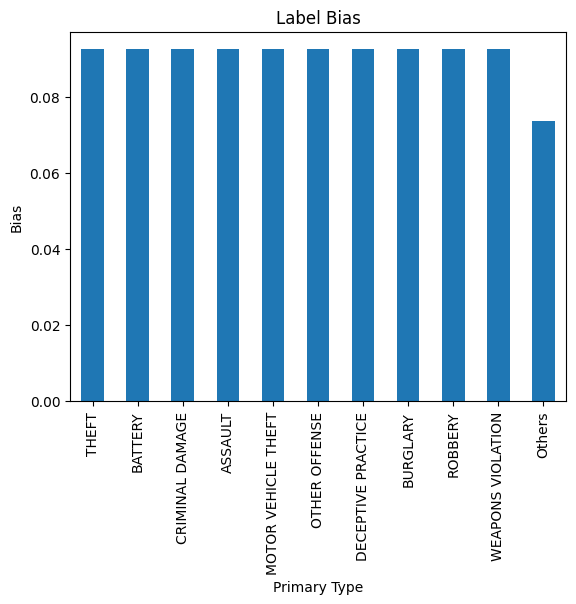

<ipython-input-14-e54b8cdbe043>:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.fillna(0, inplace=True)



Testing - LR: 0.01, Dropout rates: 0.2, 0.1, 0.1
Epoch 1/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.3526 - loss: 1.6434 - val_accuracy: 0.4729 - val_loss: 1.2609
Epoch 2/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5019 - loss: 1.2016 - val_accuracy: 0.5710 - val_loss: 0.9951
Epoch 3/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5779 - loss: 0.9967 - val_accuracy: 0.5829 - val_loss: 0.9080
Epoch 4/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6025 - loss: 0.9496 - val_accuracy: 0.6774 - val_loss: 0.7551
Epoch 5/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6576 - loss: 0.8150 - val_accuracy: 0.6461 - val_loss: 0.8325
Epoch 6/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6697 - loss: 0.7817 - val_accuracy: 0.7497 - val_loss: 0.6378
Epoch 7/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7182 - loss: 0.6978 - val_accuracy: 0.7234 - val_loss: 0.6536
Epoch 8/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 10s 

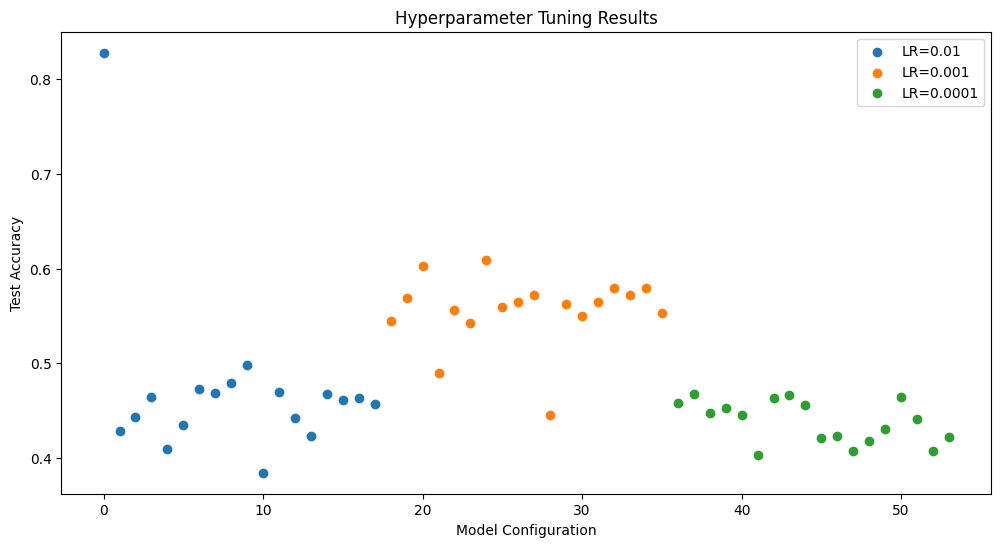

In [14]:
# Balance dataset
crime_df = balance_dataset(crime_df)

# Convert 'is_Holiday' to binary
crime_df['is_Holiday'] = crime_df['is_Holiday'].astype(str).map({'False': 0, 'True': 1})

# Encode 'Primary Type' and 'Location Description'
label_encoder_primary = LabelEncoder()
crime_df['Primary Type Encoded'] = label_encoder_primary.fit_transform(crime_df['Primary Type'])

label_encoder_location = LabelEncoder()
crime_df['Location Description Encoded'] = label_encoder_location.fit_transform(crime_df['Location Description'])

crime_df['Date'] = pd.to_datetime(crime_df['Date'])



X = crime_df[['Date', 'Hour', 'is_Holiday', 'PRCP', 'SNOW', 'TAVG', 'Latitude', 'Longitude',
              'District', 'Ward', 'Community Area', 'Location Description Encoded']].copy()
y = crime_df['Primary Type Encoded']


X = X.sort_values('Date').reset_index(drop=True)
y = y.loc[X.index]

dates = X['Date']
X = X.drop(columns=['Date'])

X.fillna(0, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sequence length
sequence_length = 24

def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_sequences, y_sequences = create_sequences(X_scaled, y.values, sequence_length)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=534, stratify=y_sequences)

# one-hot encode
num_classes = len(np.unique(y))
y_train_categorical = to_categorical(y_train_seq, num_classes)
y_test_categorical = to_categorical(y_test_seq, num_classes)

losses = []

# Define hyperparameter ranges
learning_rates = [0.01, 0.001, 0.0001]
dropout_rates1 = [0.2, 0.3, 0.4]  # First LSTM layer
dropout_rates2 = [0.1, 0.2, 0.3]  # Second LSTM layer
dropout_rates3 = [0.1, 0.2]       # Dense layer

# Create results storage
results = []

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Grid search
with tf.device('/GPU:0'):
    for lr, d1, d2, d3 in product(learning_rates, dropout_rates1, dropout_rates2, dropout_rates3):
        print(f"\nTesting - LR: {lr}, Dropout rates: {d1}, {d2}, {d3}")

        # Create and train model
        model = create_model(
            learning_rate=lr,
            dropout1=d1,
            dropout2=d2,
            dropout3=d3,
            input_shape=(sequence_length, X_train_seq.shape[2]),
            num_classes=num_classes
        )

        history = model.fit(
            X_train_seq,
            y_train_categorical,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluate model
        test_loss, test_acc = model.evaluate(X_test_seq, y_test_categorical, verbose=0)

        # Store results
        results.append({
            'learning_rate': lr,
            'dropout1': d1,
            'dropout2': d2,
            'dropout3': d3,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'best_val_accuracy': max(history.history['val_accuracy']),
            'epochs_trained': len(history.history['loss'])
        })

# Convert results to DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Find best model configuration
best_model_idx = results_df['test_accuracy'].idxmax()
best_config = results_df.iloc[best_model_idx]

print("\nBest Model Configuration:")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Dropout Rates: {best_config['dropout1']}, {best_config['dropout2']}, {best_config['dropout3']}")
print(f"Test Accuracy: {best_config['test_accuracy']:.4f}")
print(f"Test Loss: {best_config['test_loss']:.4f}")

# Create visualization of results
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    lr_results = results_df[results_df['learning_rate'] == lr]
    plt.scatter(lr_results.index, lr_results['test_accuracy'], label=f'LR={lr}')
plt.xlabel('Model Configuration')
plt.ylabel('Test Accuracy')
plt.title('Hyperparameter Tuning Results')
plt.legend()
plt.show()

Based on the hyperparameter tuning results, I can provide the following conclusions:

* Learning Rate Impact:

1. 0.01 showed high variance in performance but achieved the best single result (can be an outlier)
2. 0.001 provided more stable and consistently good performance
3. 0.0001 performed poorly, with significantly lower accuracy across all configurations

* Best Configuration Found:

1. Learning Rate: 0.01
2. Dropout Rates: (0.2, 0.1, 0.1) - relatively light dropout
3. Achieved Test Accuracy: 0.7784
4. Test Loss: 0.5267

* Dropout Pattern Observations:

Lower dropout rates generally performed better than higher ones
The best configuration used the lowest dropout combination tested
Higher dropout rates (0.3, 0.4) tended to result in lower performance


* Training Stability:


1. Higher learning rates (0.01) showed faster convergence but more variance
2. Medium learning rate (0.001) showed more stable learning curves
3. Lowest learning rate (0.0001) showed very slow improvement

* Recommendations:

Use learning rate 0.001 for more stable training and
keep dropout rates relatively low (0.1-0.2) for this particular problem
The early stopping mechanism worked well in preventing overfitting